__Radial Distribution Function__

    - calculate the RDF from the coordinates of a molecular dynamics simulation.
    - written for DL-POLY output file but can easily be used (with some modifications) for any other simulation software
    - code has been written in a parallel implementation and can be run in Pittsburgh Supercomputer 
    - reach out if you need help with anything in the code.
    
### Author: Rajendra Thapa


In [3]:
import sys

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib as mpl
from tqdm import tqdm

In [5]:
import numpy as np
from multiprocessing import Pool

def distance(atom, nbd, box):
    delta = np.abs(atom-nbd)
    delta = np.where(delta> 0.5*box, delta-box, delta)
    dis = np.sqrt((delta**2).sum(axis=-1))
    return dis

def calculate_rdf_chunk(args):
    chunk, positions, box_size, dr, max_distance = args
    n_atoms = len(positions)
    n_bins = int(max_distance / dr)
    rdf_chunk = np.zeros(n_bins)
    
    for i in chunk:
        nbd = positions[i:n_atoms][:]
        dist = distance(positions[i][:], positions[i:][:],box_size)
        for ind1 in range(len(dist)):
            if dist[ind1] < max_distance and dist[ind1] != 0.0:
                ct = int(dist[ind1]/dr)
                rdf_chunk[ct-1] += 2    
    return rdf_chunk

def rdf_parallel(positions, box_size, dr, max_distance, num_processes=128):
    n_atoms = len(positions)
    chunk_size = int(np.ceil(n_atoms / num_processes))
    chunks = [range(i, min(i + chunk_size, n_atoms)) for i in range(0, n_atoms, chunk_size)]
    
    with Pool(num_processes) as pool:
        args = [(chunk, positions, box_size, dr, max_distance) for chunk in chunks]
        results = list(pool.imap_unordered(calculate_rdf_chunk, args))
    
    rdf_values = np.sum(results, axis=0)
    
    rho = n_atoms / (box_size**3)
    shell_volume = 4 * np.pi * (np.arange(len(rdf_values)) * dr)**2 * dr
    normalization = rho * n_atoms * shell_volume
    rdf_values /= normalization
    
    return rdf_values

In [6]:
def get_coords(lines):
    seed_rad = 15.0
    coords = []
    for i in range(len(lines)):
        line = lines[i].strip()
        if line.startswith(("Li1+", "Nb5+", "O2-")):
            if i + 1 < len(lines):
                tmp = [float(item) for item in lines[i+1].split()]
    # Doing this because I have a crystal seed in the center which I don't want to go into the RDF calculation.
    # In most cases, this step is redundant
                if tmp[0]**2+tmp[1]**2+tmp[2]**2 > (seed_rad - 1.0)**2:
                    coords.append(lines[i + 1].split())
    return np.array([[float(num) for num in row] for row in coords])

Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/C0/data/15A_W0-1-nve.rcn


/var/tmp/ipykernel_69290/1767905368.py:39: RuntimeWarning: invalid value encountered in true_divide
  rdf_values /= normalization


Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/C0/data/15A_W0-3-nve.rcn
Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/C0/data/15A_W0-6-nve.rcn


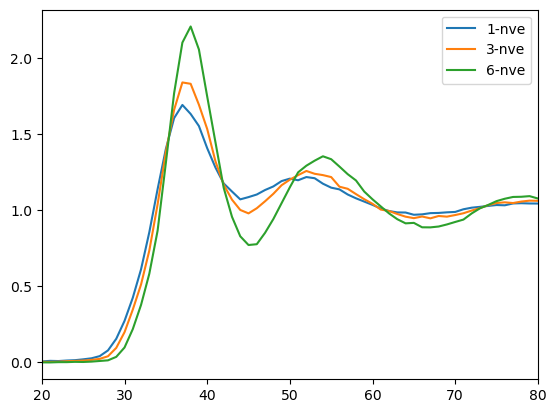

In [7]:
_dir = "/ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/C0/data"
for MQ_steps in [1,3,6]:
    for run_type in ["nve"]:#,"nve"]:   # NVT was followed by NVE in the MQ cycle
        f_name = f"{_dir}/15A_W0-{MQ_steps}-{run_type}.rcn"
        print("Working on ",f_name)
        with open(f_name) as file:
            lines = file.readlines()
        Lx, Ly, Lz = float(lines[2].split()[0]), float(lines[3].split()[1]), float(lines[4].split()[2])
        xyz_coords = get_coords(lines)
        dr = 0.05
        rdf_values = rdf_parallel(xyz_coords, Lx, dr, 0.5*Lx)
        plt.plot(rdf_values, label=f"{MQ_steps}-{run_type}")

plt.legend(loc='best')
plt.xlim(20,80)
plt.show()
        

Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/C1/data/15A_W0-9-nve.rcn


/var/tmp/ipykernel_69290/1767905368.py:39: RuntimeWarning: invalid value encountered in true_divide
  rdf_values /= normalization


Working on  /ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/C1/data/15A_W0-12-nve.rcn


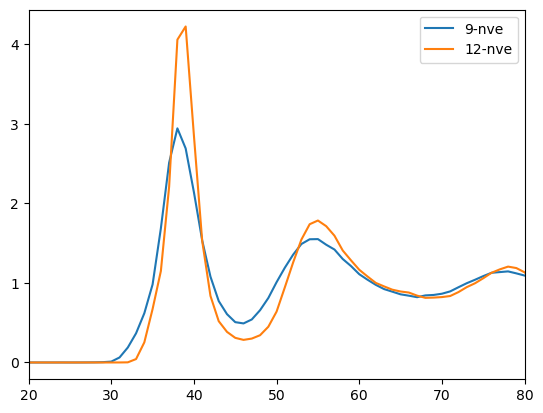

In [9]:
_dir = "/ocean/projects/mat230020p/rt887917/LiNbO3_DL_POLY/W0_1p80ns/MQ/C1/data"
for MQ_steps in [9,12]:
    for run_type in ["nve"]:#,"nve"]:   # NVT was followed by NVE in the MQ cycle
        f_name = f"{_dir}/15A_W0-{MQ_steps}-{run_type}.rcn"
        print("Working on ",f_name)
        with open(f_name) as file:
            lines = file.readlines()
        Lx, Ly, Lz = float(lines[2].split()[0]), float(lines[3].split()[1]), float(lines[4].split()[2])
        xyz_coords = get_coords(lines)
        dr = 0.05
        rdf_values = rdf_parallel(xyz_coords, Lx, dr, 0.5*Lx)
        plt.plot(rdf_values, label=f"{MQ_steps}-{run_type}")

plt.legend(loc='best')
plt.xlim(20,80)
plt.show()
        